# Dimensionality Reduction



In [1]:
import numpy as np
import pandas as pd

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import seaborn as sns
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

# Importing the 3 dimensionality reduction methods
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [2]:
train = pd.read_csv('./train.csv')
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
train.shape

(42000, 785)

In [4]:
target = train['label']
train = train.drop('label', axis=1)

# 1. Principal Component Analysis (PCA)

In a nutshell, PCA is a linear transformation algorithm that seeks to project the original features of our data onto a smaller set of features ( or subspace ) while still retaining most of the information. To do this the algorithm tries to find the most appropriate directions/angles ( which are the principal components ) that maximise the variance in the new subspace. Why maximise the variance though?

To answer the question, more context has to be given about the PCA method. One has to understand that the principal components are orthogonal to each other ( think right angle ). As such when generating the covariance matrix ( measure of how related 2 variables are to each other ) in our new subspace, the off-diagonal values of the covariance matrix will be zero and only the diagonals ( or eigenvalues) will be non-zero. It is these diagonal values that represent the variances of the principal components that we are talking about or information about the variability of our features.

Therefore when PCA seeks to maximise this variance, the method is trying to find directions ( principal components ) that contain the largest spread/subset of data points or information ( variance ) relative to all the data points present. For a brilliant and detailed description on this, check out this stackexchange thread:

[PCA and proportion of variance explained](https://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues/140579#140579) by amoeba

### Calculating the Eigenvectors

#### A Summary of the PCA Approach

- **Standardize the data:**
  In statistics, standardization is the process of putting different variables on the same scale. This process allows you to compare scores between different types of variables. Typically, to standardize variables, you calculate the mean and standard deviation for a variable. Then, for each observed value of the variable, you subtract the mean and divide by the standard deviation.

    This process produces standard scores that represent the number of standard deviations above or below the mean that a specific observation falls. For instance, a standardized value of 2 indicates that the observation falls 2 standard deviations above the mean. This interpretation is true regardless of the type of variable that you standardize.


- Obtain the Eigenvectors and Eigenvalues from the covariance matrix or correlation matrix, or perform Singular Vector Decomposition.
- Sort eigenvalues in descending order and choose the k eigenvectors that correspond to the k largest eigenvalues where k is the number of dimensions of the new feature subspace (k≤d).
- Construct the projection matrix W from the selected k eigenvectors.
- Transform the original dataset X via W to obtain a k-dimensional feature subspace Y.


One excellent article to check out for this would be:

[Principal Component Analysis in 3 Simple Steps](http://sebastianraschka.com/Articles/2015_pca_in_3_steps.html) by Sebastian Raschka

In [5]:
# Standardize the data
from sklearn.preprocessing import StandardScaler
X = train.values
X_std = StandardScaler().fit_transform(X)

# Calculating Eigenvectors and eigenvalues of Cov matrix
mean_vec = np.mean(X_std, axis=0)
cov_mat = np.cov(X_std.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i 
             in range(len(eig_vals))]

# Sorting the eigenvalue, eigenvector pair from high to low
eig_pairs.sort(key = lambda x:x[0], reverse = True)

# Calculation of Explained Variance from the eigenvalues
tot = sum(eig_vals)
var_exp = [(i/tot)*100 for i in sorted(eig_vals, reverse = True)]

cum_var_exp = np.cumsum(var_exp)

/Users/yogi/anaconda3/envs/Python3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning:

Data with input dtype int64 was converted to float64 by StandardScaler.

/Users/yogi/anaconda3/envs/Python3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning:

Data with input dtype int64 was converted to float64 by StandardScaler.



In [6]:
trace1 = go.Scatter(
    x=list(range(784)),
    y=cum_var_exp,
    mode = 'lines+markers',
    name = "'Cumulative Explained Variance'",
    line = dict(
        shape = 'spline',
        color = 'goldenrod'
        )
)
trace2 = go.Scatter(
    x = list(range(784)),
    y = var_exp,
    mode = 'lines+markers',
    name = "'Individual Explained Variance'",
    line = dict(
        shape = 'linear',
        color = 'black'
    )
)
fig = tls.make_subplots(insets = [{'cell': (1,1), 'l': 0.7
                                 ,'b':0.5}], print_grid = True)

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 1)
fig.layout.title = 'Explained Variance plots - Full and Zoomed-in'
fig.layout.xaxis = dict(range=[0,80], title = 'Feature columns')
fig.layout.yaxis = dict(range=[0,60], title = 'Explained variance')

py.iplot(fig, filename='inset example')

This is the format of your plot grid:
[ (1,1) x1,y1 ]

With insets:
[ x2,y2 ] over [ (1,1) x1,y1 ]



### Takeaway from the plot

As we can see, out of our 784 features or columns approximately 90% of the Explained Variance can be described by using just over 200 over features. So if one wanted to implement a PCA on this, extracting the top 200 features would be a very logical choice as they already account for the majority of the data. In the section below, I will use the immensely powerful Sklearn toolkit and its built-in PCA method. Unfortunately for brevity I will not be covering how to implement PCA from scratch, partly due to the multitude of resources already available.


### Visualizing the Eigenvalues

As alluded to above, since the PCA method seeks to obtain the optimal directions (or eigenvectors) that captures the most variance ( spreads out the data points the most ). Therefore it may be informative ( and cool) to visualise these directions and their associated eigenvalues. For the purposes of this notebook and for speed, I will invoke PCA to only extract the top 30 eigenvalues ( using Sklearn's .components_ call) from the digit dataset and visually compare the top 5 eigenvalues to some of the other smaller ones to see if we can glean any insights as follows:

In [7]:
n_components = 30
pca = PCA(n_components=n_components).fit(train.values)

eigenvalues = pca.components_.reshape(n_components,28,28)


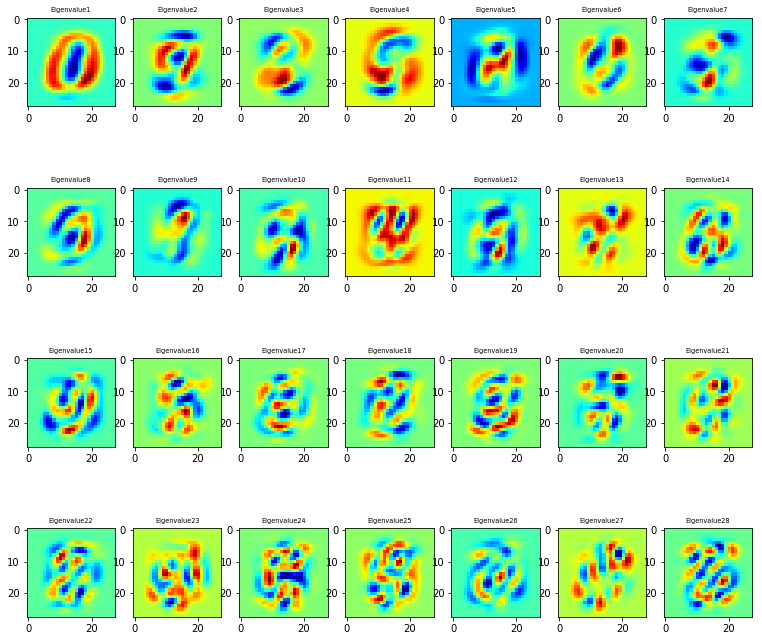

In [8]:
n_row =4
n_col = 7

plt.figure(figsize = (13,12))
for i in list(range(n_row*n_col)):
    offset = 0
    plt.subplot(n_row, n_col, i+1)
    plt.imshow(eigenvalues[i].reshape(28,28), cmap='jet')
    title_text = 'Eigenvalue' + str(i+1)
    plt.title(title_text, size=6.5)
    plt.xticks()
    plt.yticks()
plt.show()

## Visualising the MNIST Dataset

/Users/yogi/anaconda3/envs/Python3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.



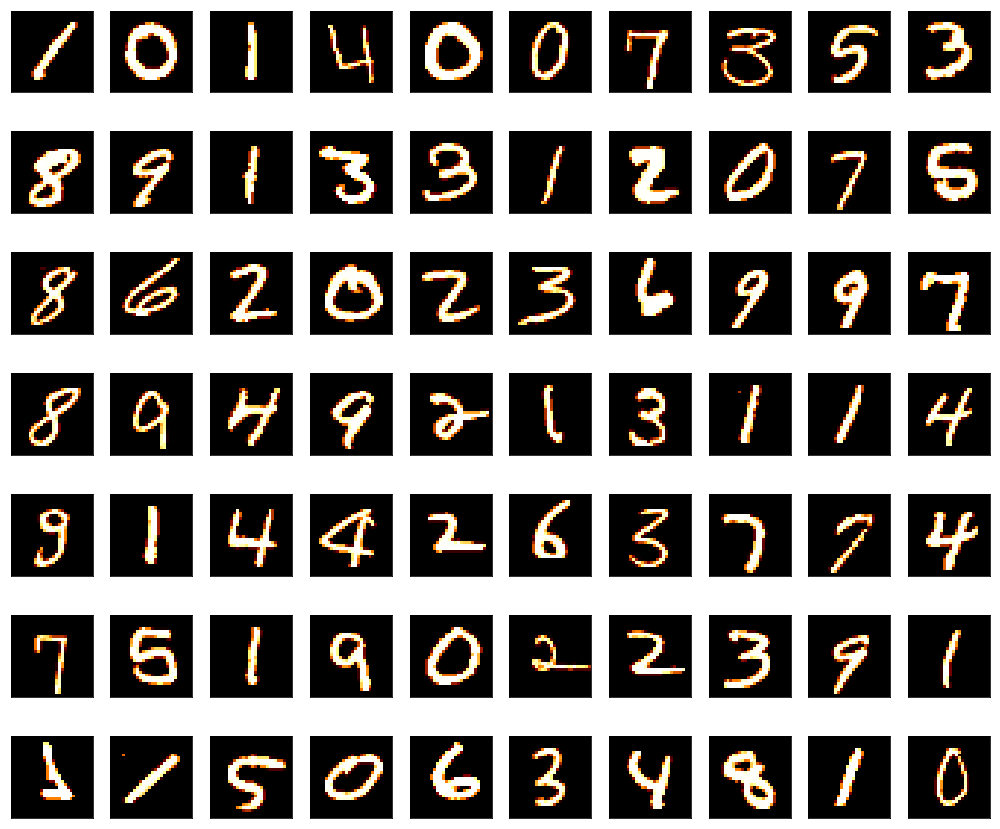

In [9]:
plt.figure(figsize=(14,12))
for digit_num in range(0,70):
    plt.subplot(7,10,digit_num+1)
    grid_data = train.iloc[digit_num].as_matrix().reshape(28,28)
    plt.imshow(grid_data, interpolation="none", cmap = "afmhot")
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()

### PCA Implementation via Sklearn

Now using the Sklearn toolkit, we implement the Principal Component Analysis algorithm as follows

In [10]:
# Delete our previous X object
del X
X = train[:6000].values

del train

X_std = StandardScaler().fit_transform(X)
pca = PCA(n_components=5)
pca.fit(X_std)
X_5d = pca.transform(X_std)

Target = target[:6000]

/Users/yogi/anaconda3/envs/Python3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning:

Data with input dtype int64 was converted to float64 by StandardScaler.

/Users/yogi/anaconda3/envs/Python3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning:

Data with input dtype int64 was converted to float64 by StandardScaler.



What the chunk of code does above is to first normalise the data (actually no need to do so for this data set as they are all 1's and 0's) using Sklearn's convenient StandardScaler call.

Next we invoke Sklearn's inbuilt PCA function by providing into its argument n_components, the number of components/dimensions we would like to project the data onto. In practise, one would educate and motivate the choice of components for example by looking at the proportion of variance captured vs each feature's eigenvalue, such as in our Explained Variance plots. To be honest, there are a multitude of papers in the literature with research on what should be a good indicator on choice of components. Here are some references for the interested: However for the essence of this notebook being a guide of sorts, I have just decided to take a PCA on 5 components ( against perhaps taking 200 over components).

Finally I call both fit and transform methods which fits the PCA model with the standardised digit data set and then does a transformation by applying the dimensionality reduction on the data.

In [11]:
trace0 = go.Scatter(
    x = X_5d[:,0],
    y = X_5d[:,1],
    mode = 'markers',
    text = Target,
    showlegend = False,
    marker = dict(
        size = 8,
        color = Target,
        colorscale = 'Jet',
        showscale = False,
        line = dict(
            width = 2,
            color = 'rgb(255, 255, 255)'
        ),
        opacity = 0.8
    )
)
data = [trace0]

layout = go.Layout(
    title = 'Principal Component Analysis (PCA)',
    hovermode = 'closest',
    xaxis = dict(
        title = 'First Principal Component',
        ticklen = 5,
        zeroline = False,
        gridwidth =2
    ),
    yaxis = dict(
        title = 'Second Principal Component',
        ticklen = 5,
        gridwidth = 2
    ),
    showlegend = True
)

    
fig = dict(data=data, layout=layout)
py.iplot(fig, filename = 'styled-scatter')


### Takeaway from the Plot

As observed from the scatter plot, you can just about make out a few discernible clusters evinced from the collective blotches of colors. These clusters represent the underlying digit that each data point should contribute to and one may therefore be tempted to think that it was quite a piece of cake in implementing and visualising PCA in this section.

However, the devil lies in the tiny details of the python implementation because as alluded to earlier, PCA is actually in fact an unsupervised method which does not depend on class labels. I have sneakily snuck in class labelings whilst generating the scatter plots therefore resulting in the clusters of colours as you see them.

### K-Means Clustering to identify possible classes

Imagine just for a moment that we were not provided with the class labels to this digit set because after all PCA is an unsupervised method. Therefore how would we be able to separate out our data points in the new feature space? We can apply a clustering algorithm on our new PCA projection data and hopefully arrive at distinct clusters which would tell us something about the underlying class separation in the data.

To start off, we set up a KMeans clustering method with Sklearn's KMeans call and use the fit_predict method to compute cluster centers and predict cluster indices for the first and second PCA projections (to see if we can observe any appreciable clusters).

In [18]:
from sklearn.cluster import KMeans # KMeans clustering 
# Set a KMeans clustering with 9 components ( 9 chosen sneakily ;) as hopefully we get back our 9 class labels)
kmeans = KMeans(n_clusters=9)
# Compute cluster centers and predict cluster indices
X_clustered = kmeans.fit_predict(X_5d)

trace_Kmeans = go.Scatter(x=X_5d[:, 0], y= X_5d[:, 1], mode="markers",
                    showlegend=False,
                    marker=dict(
                            size=8,
                            color = X_clustered,
                            colorscale = 'Portland',
                            showscale=False, 
                            line = dict(
            width = 2,
            color = 'rgb(255, 255, 255)'
        )
                   ))

layout = go.Layout(
    title= 'KMeans Clustering',
    hovermode= 'closest',
    xaxis= dict(
         title= 'First Principal Component',
        ticklen= 5,
        zeroline= False,
        gridwidth= 2,
    ),
    yaxis=dict(
        title= 'Second Principal Component',
        ticklen= 5,
        gridwidth= 2,
    ),
    showlegend= True
)

data = [trace_Kmeans]
fig1 = dict(data=data, layout= layout)
# fig1.append_trace(contour_list)
py.iplot(fig1, filename="svm")


### Takeaway from the Plot

Visually, the clusters generated by the KMeans algorithm appear to provide a clearer demarcation amongst clusters as compared to naively adding in class labels into our PCA projections. This should come as no surprise as PCA is meant to be an unsupervised method and therefore not optimised for separating different class labels. This particular task however is accomplished by the very next method that we will talk about.

# 2. Linear Discriminant Analysis (LDA)¶

LDA, much like PCA is also a linear transformation method commonly used in dimensionality reduction tasks. However unlike the latter which is an unsupervised learning algorithm, LDA falls into the class of supervised learning methods. As such the goal of LDA is that with available information about class labels, LDA will seek to maximise the separation between the different classes by computing the component axes (linear discriminants ) which does this.

In [20]:
from IPython.display import display, Math, Latex

### LDA Implementation from Scratch

The objective of LDA is to preserve the class separation information whilst still reducing the dimensions of the dataset. As such implementing the method from scratch can roughly be split into 4 distinct stages as below. As an aside, since this section will be quite equation heavy therefore we will also be embedding some mathematical equations into the upcoming sections. The good thing about IPython notebook is that you can render your equations (LaTeX) automatically by putting them within the $$ symbol, courtesy of the use of MathJax - a JavaScript equation display engine.

#### A. Projected Means

Since this method was designed to take into account class labels we therefore first need to establish a suitable metric with which to measure the 'distance' or separation between different classes. Let's assume that we have a set of data points x that belong to one particular class w. Therefore in LDA the first step is to the project these points onto a new line, Y that contains the class-specific information via the transformation

                            Y=ω⊺x
 
With this the idea is to find some method that maximises the separation of these new projected variables. To do so, we first calculate the projected mean.

#### B. Scatter Matrices and their solutions 
Having introduced our projected means, we now need to find a function that can represent the difference between the means and then maximise it. Like in linear regression, where the most basic case is to find the line of best fit we need to find the equivalent of the variance in this context. And hence this is where we introduce scatter matrices where the scatter is the equivalent of the variance.

                            S̃ 2=(y−mu~)2
 
#### C. Selecting Optimal Projection Matrices

#### D. Transforming features onto new subspace

### LDA Implementation via Sklearn
Having gone through the nitty-gritty details of the LDA implementation in theory, let us now implement the method in practise. Surprise, surprise we find that the Sklearn toolkit also comes with its own inbuilt LDA function and hence we invoke an LDA model as follows:

In [24]:
lda = LDA(n_components=5)
# Taking in as second argument the Target as labels
X_LDA_2D = lda.fit_transform(X_std, Target.values)

/Users/yogi/anaconda3/envs/Python3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



The syntax for the LDA implementation is very much akin to that of PCA whereby one calls the fit and transform methods which fits the LDA model with the data and then does a transformation by applying the LDA dimensionality reduction to it. However since LDA is a supervised learning algorithm , there is a second argument to the method that the user must provide and this would be the class labels, which in this case is the target labels of the digits.

## Interactive visualisations of LDA representation

In [40]:
traceLDA = go.Scatter(
            x = X_LDA_2D[:,0],
            y = X_LDA_2D[:,1],
            mode = "markers",
            text = Target,
            marker = dict(
                size = 8,
                color = Target,
                colorscale = 'Jet',
                showscale = False,
                line = dict(
            width = 2,
            color = 'rgb(255, 255, 255)'
        ),
        opacity = 0.8
            )
            )

data = [traceLDA]

layout = go.Layout(
            title = 'Linear Discriminant Analysis',
            hovermode = 'closest',
            xaxis= dict(
                     title= 'First Linear Discriminant',
                    ticklen= 5,
                    zeroline= False,
                    gridwidth= 2,
                ),
            yaxis = dict(
            title = 'Second Linear Discriminant'
            ),
        showlegend = False
            )

fig = dict(data=data, layout=layout)
py.iplot(fig, filename = 'styled-scatter')

From the scatter plot above, we can see that the data points are more clearly clustered when using LDA with as compared to implementing PCA with class labels. This is an inherent advantage in having class labels to supervise the method with. In short picking the right tool for the right job.

# 3. T-SNE ( t-Distributed Stochastic Neighbour Embedding )
The t-SNE method has become widely popular ever since it was introduced by van der Maaten and Hinton in 2008. Unlike the previous two linear methods of PCA and LDA discussed above, t-SNE is a non-linear, probabilistic dimensionality reduction method.

The internal mechanisms of the algorithm Therefore instead of looking at directions/axes which maximise information or class separation, T-SNE aims to convert the Euclidean distances between points into conditional probabilities. A Student-t distribution is then applied on these probabilities which serve as metrics to calculate the similarity between one datapoint to another.

However this brief summary does no justice in any manner or shape to the original t-SNE paper by Maaten and Hinton so please do check the original out [here](http://www.cs.toronto.edu/~hinton/absps/tsne.pdf).

In [41]:
# Invoking the t-SNE method
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(X_std) 

Having invoked the t-SNE algorithm by simply calling TSNE() we fit the digit data to the model and reduce its dimensions with fit_transform. Finally let's plot the first two components in the new feature space in a scatter plot

In [50]:
traceTSNE = go.Scatter(
    x = tsne_results[:,0],
    y = tsne_results[:,1],
    mode = 'markers',
    text = Target,
    showlegend = True,
    marker = dict(
        size = 8,
        color = Target,
        colorscale ='Jet',
        showscale = False,
        line = dict(
            width = 2,
            color = 'rgb(255, 255, 255)'
        ),
        opacity = 0.8
    )
)
data = [traceTSNE]

layout = dict(title = 'TSNE (T-Distributed Stochastic Neighbour Embedding)',
              hovermode= 'closest',
              yaxis = dict(zeroline = False),
              xaxis = dict(zeroline = False),
              showlegend= False
             )

fig = dict(data=data, layout=layout)
py.iplot(fig, filename='styled-scatter')

### Takeaway from the Plots

From the t-SNE scatter plot the first thing that strikes is that clusters ( and even subclusters ) are very well defined and segregated resulting in Jackson-Pollock like Modern Art visuals, even more so than the PCA and LDA methods. This ability to provide very good cluster visualisations can be boiled down to the topology-preserving attributes of the algorithm.

However t-SNE is not without its drawbacks. Multiple local minima may occur as the algorithm is identifying clusters/sub-clusters and this can be evinced from the scatter plot, where we can see that clusters of the same colour exist as 2 sub-clusters in different areas of the plot.